The aim of this notebook is to explore FLARE2022 dataset.

# Imports & constants

In [1]:
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    EnsureTyped,
    ScaleIntensityRanged,
    Orientationd,
    Spacingd,
    RandCropByPosNegLabeld
)
from monai.data import Dataset, DataLoader
from monai.utils import first

In [2]:
DATA_DIR = '../data/finetune'

# Exploration

In [3]:
img_paths = sorted((Path(DATA_DIR)/Path('imgs')).glob('*.nii.gz'))
label_paths = sorted((Path(DATA_DIR)/Path('labels')).glob('*.nii.gz'))
data = [{'img': img_path, 'label': label_path} 
        for img_path, label_path in zip(img_paths, label_paths)]

### Pixel sizes

First of all, let's explore pixel sizes.

In [4]:
transforms = Compose([
    LoadImaged(keys=['img', 'label']),
])
dataset = Dataset(data, transform=transforms)

xy_dims = []
z_dims = []
for i in range(len(dataset)):
    pixdims = dataset[i]['img_meta_dict']['pixdim']
    xy_dims.append(round(pixdims[1], 1))  # Assuming they're the same
    z_dims.append(round(pixdims[3], 1))

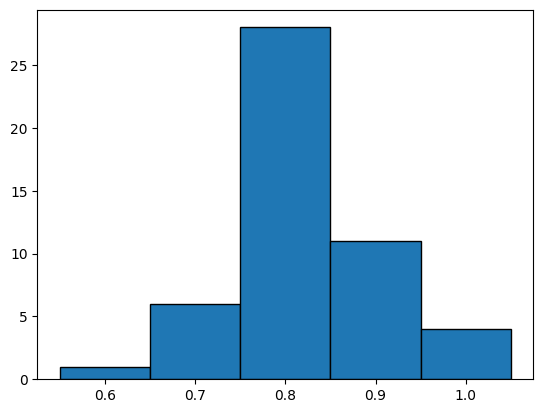

In [5]:
xy_dims = Counter(xy_dims)

plt.bar(xy_dims.keys(), xy_dims.values(), width=0.1, edgecolor='black')
plt.show()

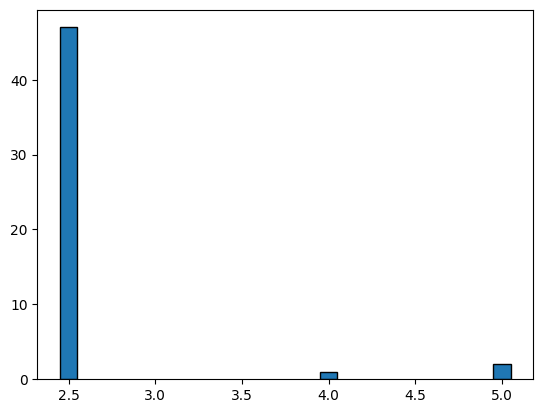

In [6]:
z_dims = Counter(z_dims)

plt.bar(z_dims.keys(), z_dims.values(), width=0.1, edgecolor='black')
plt.show()

### HU values

Let's also take a look at distribution of HU values of organs to be detected.

In [15]:
organ_pixels = []

for i in range(len(dataset)):
    if i % 5 == 0:
        data_dict = dataset[i]
        mask = data_dict['label'] > 0
        organ_pixels.extend(data_dict['img'][mask].tolist())

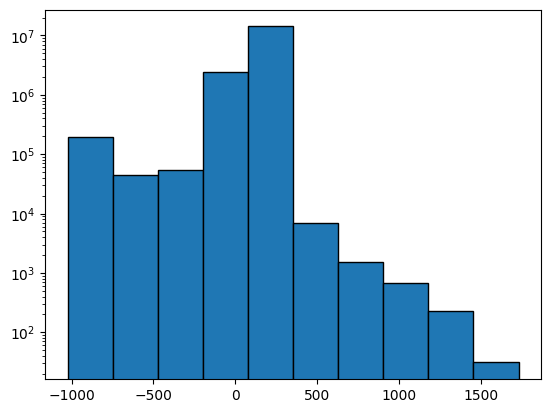

In [16]:
plt.hist(organ_pixels, edgecolor='black')
plt.yscale('log')
plt.show()

In [17]:
del organ_pixels

### Labels

Finally, let's visualize some (img, label) pairs.

In [19]:
transforms = Compose([
    LoadImaged(keys=['img', 'label']),
    EnsureChannelFirstd(keys=['img', 'label']),
    Orientationd(keys=['img', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['img'], a_min=-500, a_max=500,
                            b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['img', 'label'], source_key='img'),
    Spacingd(keys=['img', 'label'], pixdim=(1, 1, 2.5), 
                mode=('bilinear', 'nearest')),
    EnsureTyped(keys=['img', 'label'], device='cpu', track_meta=False),
    RandCropByPosNegLabeld(
        keys=['img', 'label'],
        label_key='label',
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=2,
        image_key='img',
        image_threshold=0,
    )
])

In [20]:
dataset = Dataset(data=data, transform=transforms)
sample = dataset[0]

In [21]:
sample

[{'img': tensor([[[[0.4279, 0.5405, 0.5911,  ..., 0.0000, 0.0000, 0.0000],
            [0.4154, 0.5168, 0.5949,  ..., 0.0000, 0.0000, 0.0000],
            [0.4240, 0.5036, 0.5985,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [0.0000, 0.0418, 0.2264,  ..., 0.4028, 0.4068, 0.4527],
            [0.0000, 0.0000, 0.0000,  ..., 0.4447, 0.4706, 0.4825],
            [0.0000, 0.0000, 0.0000,  ..., 0.4993, 0.4927, 0.3388]],
  
           [[0.4295, 0.5359, 0.5882,  ..., 0.0000, 0.0000, 0.0000],
            [0.4191, 0.5207, 0.5953,  ..., 0.0000, 0.0000, 0.0000],
            [0.4191, 0.5029, 0.6013,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [0.0226, 0.2069, 0.4154,  ..., 0.3937, 0.3990, 0.4382],
            [0.0000, 0.0000, 0.0963,  ..., 0.4153, 0.4443, 0.4944],
            [0.0000, 0.0000, 0.0000,  ..., 0.5055, 0.5297, 0.4450]],
  
           [[0.4360, 0.5337, 0.5887,  ..., 0.0000, 0.0000, 0.0000],
            [0.4153, 0.5095, 0.5834,  ..., 0.0000, 0.0000, 0.0000],

Note that when using `Dataset` only, a list of data dictionaries are returned 
(data isn't fully collated yet).

In [22]:
sample[0]['label'].unique()

tensor([ 0.,  1.,  4.,  6., 11., 12.])

Labels are encoded using integers.

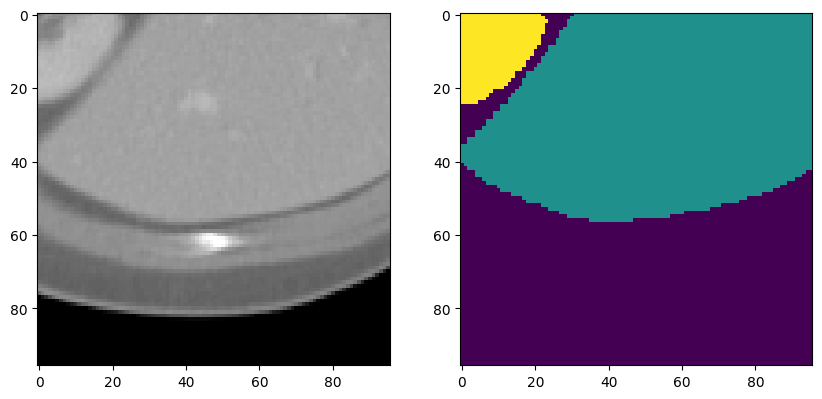

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(sample[1]['img'][0, :, :, 50], cmap='gray')
axs[1].imshow(sample[1]['label'][0, :, :, 50])
plt.show()

Let's see what happens when using `DataLoader`.

In [24]:
loader = DataLoader(dataset, shuffle=False)
data_dict = first(loader)
imgs = data_dict['img']
labels = data_dict['label']

In [25]:
imgs.shape, labels.shape

(torch.Size([2, 1, 96, 96, 96]), torch.Size([2, 1, 96, 96, 96]))

The data is now collated properly.

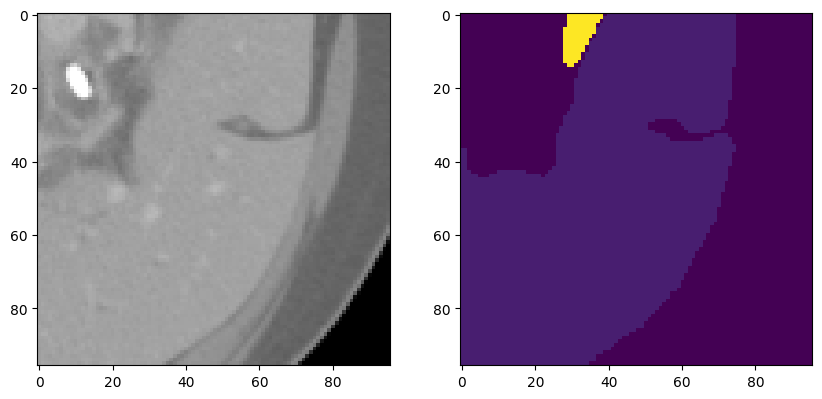

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(imgs[0, 0, :, :, 50], cmap='gray')
axs[1].imshow(labels[0, 0, :, :, 50])
plt.show()